In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset path
data_dir = r"E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


In [2]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    
    def forward(self, x):
        return self.features(x)

# Initialize CNN
cnn_model = CNNFeatureExtractor().to(device)


In [3]:
class CAEFeatureExtractor(nn.Module):
    def __init__(self):
        super(CAEFeatureExtractor, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize CAE
cae_model = CAEFeatureExtractor().to(device)


In [4]:
def extract_features(model, dataloader, device, is_cae=False):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            if is_cae:
                encoded, _ = model(images)  # For CAE, use encoded features
                features.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            else:
                output = model(images)
                features.append(output.view(output.size(0), -1).cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(features), np.array(labels)

# Extract features using CNN
cnn_features, cnn_labels = extract_features(cnn_model, train_loader, device)

# Extract features using CAE
cae_features, cae_labels = extract_features(cae_model, train_loader, device, is_cae=True)


In [ ]:
# Combine features
combined_features = np.hstack((cnn_features, cae_features))
print(f"Combined feature shape: {combined_features.shape}")


In [6]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANNClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize ANN
input_size = combined_features.shape[1]
num_classes = len(dataset.classes)
ann_model = ANNClassifier(input_size, num_classes).to(device)


In [ ]:
def train_ann(model, features, labels, num_epochs=10, batch_size=16, learning_rate=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Convert features and labels to tensors
    dataset = torch.utils.data.TensorDataset(torch.tensor(features, dtype=torch.float32),
                                              torch.tensor(labels, dtype=torch.long))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
        
        accuracy = correct / total * 100
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Train ANN
train_ann(ann_model, combined_features, cnn_labels)


In [ ]:
# Adjusting n_components to a value less than the number of samples
pca = PCA(n_components=100)  # Reduce to 100 dimensions
reduced_features = pca.fit_transform(combined_features)
print(f"Reduced feature shape: {reduced_features.shape}")


In [15]:
class ImprovedANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize improved ANN
improved_ann_model = ImprovedANN(input_size=reduced_features.shape[1], num_classes=num_classes).to(device)


In [ ]:
train_ann(improved_ann_model, reduced_features, cnn_labels)


In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure you have true labels and predicted labels
# Replace `true_labels` and `predicted_labels` with actual data from your model
true_labels = cnn_labels  # Replace with actual labels
predicted_labels = torch.argmax(improved_ann_model(torch.tensor(reduced_features, dtype=torch.float32).to(device)), axis=1).cpu().numpy()

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_labels))
plt.figure(figsize=(10, 7))
disp.plot(cmap='viridis', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# Replace these with your actual test labels and predictions
test_labels = cnn_labels  # Ground truth labels
test_preds = torch.argmax(improved_ann_model(torch.tensor(reduced_features, dtype=torch.float32).to(device)), axis=1).cpu().numpy()  # Model predictions
class_to_idx = dataset.class_to_idx  # Assuming your dataset has a class_to_idx attribute

# Generate and save the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_to_idx.keys()))
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
# Optional: Uncomment if you want to set a title
# plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()



#t.savefig(f"{output_dir}/confusion_matrix.png", dpi=300)
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Extract features from the test dataset using both CNN and CAE
cnn_test_features = []
cae_test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        
        # Extract features using CNN
        cnn_output = cnn_model(images)
        cnn_flattened = cnn_output.view(cnn_output.size(0), -1).cpu().numpy()
        cnn_test_features.append(cnn_flattened)
        
        # Extract features using CAE
        cae_encoded, _ = cae_model(images)
        cae_flattened = cae_encoded.view(cae_encoded.size(0), -1).cpu().numpy()
        cae_test_features.append(cae_flattened)
        
        test_labels.extend(labels.numpy())

# Combine features from CNN and CAE
cnn_test_features = np.vstack(cnn_test_features)
cae_test_features = np.vstack(cae_test_features)
test_combined_features = np.hstack((cnn_test_features, cae_test_features))

# Reduce dimensions using PCA
test_reduced_features = pca.transform(test_combined_features)

# Generate predictions using the trained ANN model
test_reduced_features = torch.tensor(test_reduced_features, dtype=torch.float32).to(device)
test_preds = torch.argmax(improved_ann_model(test_reduced_features), axis=1).cpu().numpy()

# Generate and save the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_to_idx.keys()))
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the confusion matrix plot
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
#lt.savefig(f"{output_dir}/test_confusion_matrix.png", dpi=300)
plt.show()


In [ ]:
# Print the classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=list(class_to_idx.keys())))

In [ ]:
# Print unique values in labels and class_to_idx for debugging
print("Unique labels in dataset:", np.unique(labels))
print("Class-to-Index Mapping:", class_to_idx)


In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

# Extract features from the test dataset using both CNN and CAE
cnn_test_features = []
cae_test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        
        # Extract features using CNN
        cnn_output = cnn_model(images)
        cnn_flattened = cnn_output.view(cnn_output.size(0), -1).cpu().numpy()
        cnn_test_features.append(cnn_flattened)
        
        # Extract features using CAE
        cae_encoded, _ = cae_model(images)
        cae_flattened = cae_encoded.view(cae_encoded.size(0), -1).cpu().numpy()
        cae_test_features.append(cae_flattened)
        
        test_labels.extend(labels.numpy())

# Combine features from CNN and CAE
cnn_test_features = np.vstack(cnn_test_features)
cae_test_features = np.vstack(cae_test_features)
test_combined_features = np.hstack((cnn_test_features, cae_test_features))

# Reduce dimensions using PCA
test_reduced_features = pca.transform(test_combined_features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(test_reduced_features)

# Map numeric labels to class names
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse the mapping
class_labels = [idx_to_class[label] for label in test_labels]
cmap = plt.cm.get_cmap("tab20") 
# Plot t-SNE
plt.figure(figsize=(7,5)),
sns.scatterplot(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    hue=class_labels,  # Use class names for hue
    palette=cmap(np.linspace(0, 1, len(class_to_idx))),
    legend="full",
    s=80,  # Marker size
    alpha=0.9,  # Marker transparency
    edgecolor="black",
    linewidth=0.5
)


plt.legend(title="Classes", fontsize=10, loc="best")
plt.tight_layout()


# Show the plot
plt.show()


In [1]:
import os
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dataset path
data_dir = r"E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load dataset
test_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Mapping classes to indices
class_to_idx = test_dataset.class_to_idx
print("Class-to-Index Mapping:", class_to_idx)


Class-to-Index Mapping: {'BF': 0, 'BFI': 1, 'GF': 2, 'GFI': 3, 'N': 4, 'NI': 5, 'TF': 6}


In [2]:
import torch.nn as nn

# Define placeholder CNN model (replace with your actual model)
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

    def forward(self, x):
        return self.features(x)

# Define placeholder CAE model (replace with your actual model)
class CAEFeatureExtractor(nn.Module):
    def __init__(self):
        super(CAEFeatureExtractor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded, None

# Instantiate models
cnn_model = CNNFeatureExtractor().to(device)
cae_model = CAEFeatureExtractor().to(device)

# Load pre-trained weights if available
# cnn_model.load_state_dict(torch.load("path_to_cnn_weights.pth"))
# cae_model.load_state_dict(torch.load("path_to_cae_weights.pth"))

# Set models to evaluation mode
cnn_model.eval()
cae_model.eval()


CAEFeatureExtractor(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
)

In [3]:
cnn_features = []
cae_features = []
labels = []

# Feature extraction loop
with torch.no_grad():
    for images, batch_labels in test_loader:
        images = images.to(device)

        # Extract features using CNN
        cnn_output = cnn_model(images)
        cnn_features.append(cnn_output.cpu().numpy())

        # Extract features using CAE
        cae_output, _ = cae_model(images)
        cae_features.append(cae_output.cpu().numpy())

        # Collect labels
        labels.extend(batch_labels.numpy())

# Convert to numpy arrays
cnn_features = np.vstack(cnn_features)
cae_features = np.vstack(cae_features)
labels = np.array(labels)

print("CNN Features Shape:", cnn_features.shape)
print("CAE Features Shape:", cae_features.shape)
print("Labels Shape:", labels.shape)


CNN Features Shape: (280, 200704)
CAE Features Shape: (280, 200704)
Labels Shape: (280,)


In [4]:
# Combine CNN and CAE features
combined_features = np.hstack((cnn_features, cae_features))
print("Combined Features Shape:", combined_features.shape)


Combined Features Shape: (280, 401408)


In [5]:
# Dimensionality reduction using PCA
from sklearn.decomposition import PCA

# Set the number of PCA components to match the ANN input size
input_size = 100  # This should match the input size of your ANN model
pca = PCA(n_components=input_size)

# Fit and transform the combined features
reduced_features = pca.fit_transform(combined_features)
print("Reduced Features Shape:", reduced_features.shape)


Reduced Features Shape: (280, 100)


In [6]:
import torch.nn as nn

# Define the ANN model
class ImprovedANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

# Instantiate and move the ANN model to the device
num_classes = len(class_to_idx)
ann_model = ImprovedANN(input_size=input_size, num_classes=num_classes).to(device)

# Load pre-trained weights if available
# ann_model.load_state_dict(torch.load("path_to_ann_weights.pth"))

# Set the ANN model to evaluation mode
ann_model.eval()


ImprovedANN(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [7]:
# Convert reduced features to a tensor
reduced_features_tensor = torch.tensor(reduced_features, dtype=torch.float32).to(device)

# Get logits from the ANN model
with torch.no_grad():
    outputs = ann_model(reduced_features_tensor)
    probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities

print("Probabilities Shape:", probs.shape)


Probabilities Shape: (280, 7)


In [8]:
from sklearn.preprocessing import label_binarize

# Binarize the labels (one-hot encoding for multi-class ROC)
y_true = label_binarize(labels, classes=range(num_classes))
print("Binarized Labels Shape:", y_true.shape)


Binarized Labels Shape: (280, 7)


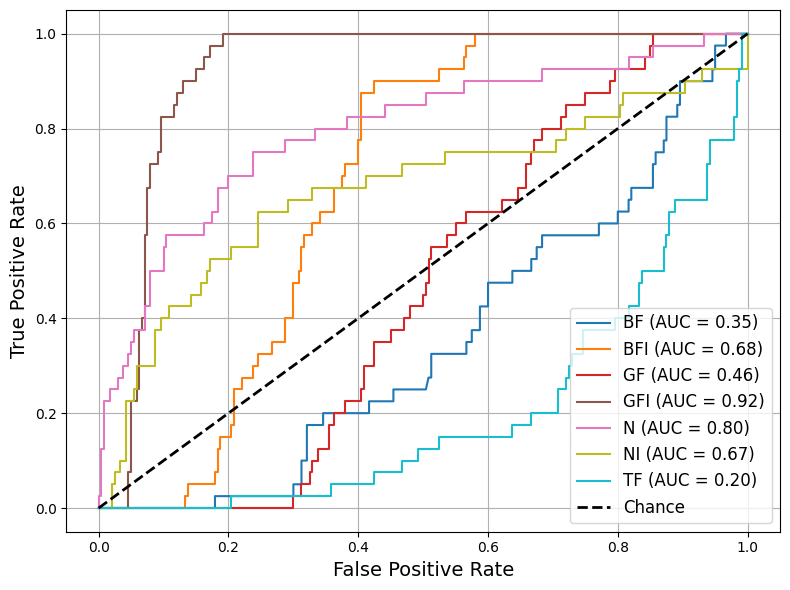

In [9]:
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

for i, class_name in enumerate(class_to_idx.keys()):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', color=colors[i])

# Plot the diagonal for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


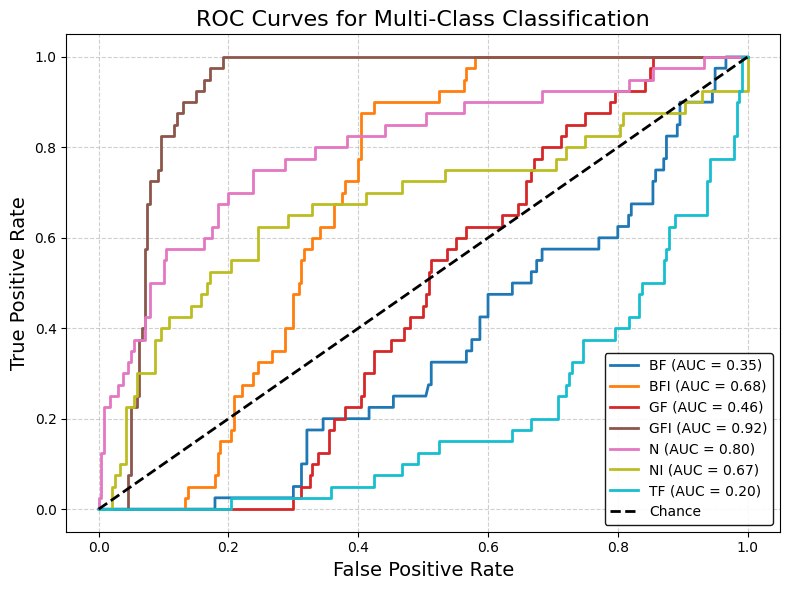

In [10]:
# Plot ROC curves for each class with cleaner styling
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

for i, class_name in enumerate(class_to_idx.keys()):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', color=colors[i], lw=2)

# Plot the diagonal for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=0.9, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot as an image
plt.savefig("roc_curves_cleaned.png", dpi=300)
plt.show()
